In [267]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (confusion_matrix, f1_score, recall_score, precision_score, 
                            accuracy_score, roc_curve, auc, roc_auc_score, 
                            log_loss, brier_score_loss, classification_report)
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import shap



In [268]:
df = pd.read_csv('shots_2007-2023.csv')
print(f"Dataset Shape: {df.shape}")
print(df.head())

print(f"\nTarget variable 'goal' distribution:\n{df['goal'].value_counts()}")
print(f"Goal rate: {df['goal'].mean():.4f}")


Dataset Shape: (1840218, 124)
   shotID homeTeamCode awayTeamCode  season  isPlayoffGame  game_id  \
0       0          TBL          NSH    2023              0    20001   
1       1          TBL          NSH    2023              0    20001   
2       2          TBL          NSH    2023              0    20001   
3       3          TBL          NSH    2023              0    20001   
4       4          TBL          NSH    2023              0    20001   

   homeTeamWon  id  time  timeUntilNextEvent  ...    xFroze  xRebound  \
0            1  10    61                 9.0  ...  0.249174  0.035816   
1            1  11    70                26.0  ...  0.107945  0.051284   
2            1  13   107                 2.0  ...  0.236193  0.030269   
3            1  19   177                35.0  ...  0.198635  0.033686   
4            1  21   231                29.0  ...  0.188582  0.027146   

  xPlayContinuedInZone xPlayContinuedOutsideZone xPlayStopped  xShotWasOnGoal  \
0             0.379310 

             shotID        season  isPlayoffGame       game_id   homeTeamWon  \
count  1.840218e+06  1.840218e+06   1.840218e+06  1.840218e+06  1.840218e+06   
mean   9.201085e+05  2.015146e+03   7.252782e-02  2.130252e+04  5.417787e-01   
std    5.312253e+05  4.960793e+00   2.593599e-01  2.513023e+03  4.982516e-01   
min    0.000000e+00  2.007000e+03   0.000000e+00  2.000100e+04  0.000000e+00   
25%    4.600542e+05  2.011000e+03   0.000000e+00  2.032200e+04  0.000000e+00   
50%    9.201085e+05  2.015000e+03   0.000000e+00  2.064400e+04  1.000000e+00   
75%    1.380163e+06  2.019000e+03   0.000000e+00  2.098600e+04  1.000000e+00   
max    1.840217e+06  2.023000e+03   1.000000e+00  3.041700e+04  1.000000e+00   

                 id          time  timeUntilNextEvent  timeSinceLastEvent  \
count  1.840218e+06  1.840218e+06        1.840218e+06        1.840218e+06   
mean   1.607135e+02  1.835555e+03        1.145011e+01        1.570407e+01   
std    9.231472e+01  1.058338e+03        1.49593

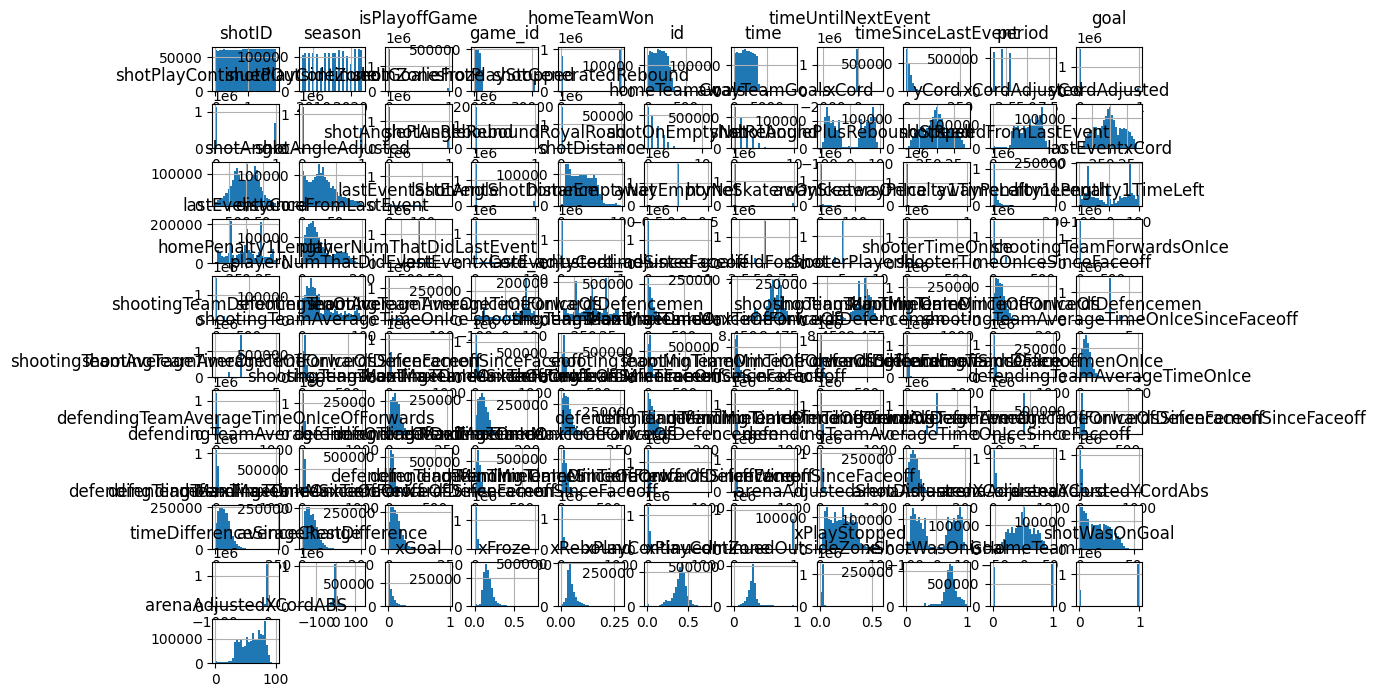

In [269]:
print(df.describe())
print(f"\nData Types:\n{df.dtypes}")

missing_data = df.isnull().sum()
print(f"\nMissing values: {missing_data.sum()}")
if missing_data.sum() > 0:
    df = df.dropna()

print(f"Duplicates: {df.duplicated().sum()}")
if df.duplicated().sum() > 0:
    df = df.drop_duplicates()

numeric_cols = df.select_dtypes(include="number").columns
df[numeric_cols].hist(figsize=(12, 8), bins=30)
plt.tight_layout()
plt.show()

In [270]:
xg_features = [col for col in df.columns if col.startswith('x') and col != 'xCord' and col != 'xCordAdjusted']
df = df.drop(columns=xg_features)

# Exclude outcome-related features that leak information about the shot result
# 'event' encodes the outcome (GOAL, MISS, SHOT) - this is the target!
# 'goal' is the target variable itself - DO NOT drop it!
leakage_features = ['shotWasOnGoal', 'homeTeamWon', 'event']
leakage_features = [col for col in leakage_features if col in df.columns]
if leakage_features:
    df = df.drop(columns=leakage_features)
    print(f"Excluded outcome/leakage features: {leakage_features}")

# Check if lastEventCategory contains goal-related info and exclude if so
if 'lastEventCategory' in df.columns:
    if df['lastEventCategory'].dtype == 'object':
        unique_events = df['lastEventCategory'].unique()
        if 'GOAL' in str(unique_events):
            df = df.drop(columns=['lastEventCategory'])
            print(f"Excluded 'lastEventCategory' (contains GOAL information)")

# Check if 'goal' column exists before accessing it
if 'goal' not in df.columns:
    print(f"Error: 'goal' column not found in dataframe!")
    print(f"Available columns: {df.columns.tolist()}")
    # Try to find potential target columns
    potential_targets = [col for col in df.columns if 'goal' in col.lower() or 'target' in col.lower()]
    if potential_targets:
        print(f"Potential target columns found: {potential_targets}")
    raise KeyError("'goal' column is missing. Please check if it was accidentally dropped or renamed.")
else:
    print(f"Target distribution:\n{df['goal'].value_counts()}")
    print(f"Goal rate: {df['goal'].mean():.4f}")

print(f"\nExcluded {len(xg_features)} xG-related features to prevent data leakage")

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

Excluded outcome/leakage features: ['shotWasOnGoal', 'homeTeamWon', 'event']
Excluded 'lastEventCategory' (contains GOAL information)
Target distribution:
goal
0    1706023
1     116885
Name: count, dtype: int64
Goal rate: 0.0641

Excluded 7 xG-related features to prevent data leakage


In [271]:
# Only encode categorical features that don't leak outcome information
# Exclude 'lastEventCategory' if it contains GOAL (already handled above)
categorical_cols_to_encode = ['shotType', 'shooterLeftRight']
# Only add lastEventCategory if it wasn't excluded
if 'lastEventCategory' in df.columns:
    categorical_cols_to_encode.append('lastEventCategory')

ohe_cols = [col for col in categorical_cols_to_encode if col in df.columns]
if ohe_cols:
    df = pd.get_dummies(df, columns=ohe_cols, drop_first=False)
    print(f"One-hot encoded columns: {ohe_cols}")
    
    # Ensure encoded columns are numeric (they should be, but verify)
    encoded_cols = [col for col in df.columns if any(col.startswith(prefix) for prefix in ohe_cols)]
    for col in encoded_cols:
        if df[col].dtype == 'object':
            df[col] = df[col].astype(int)

drop_cols = ['shotID', 'homeTeamCode', 'awayTeamCode', 'game_id', 'id', 'teamCode', 
             'shooterName', 'goalieNameForShot', 'playerPositionThatDidEvent']
drop_cols = [col for col in drop_cols if col in df.columns]
if drop_cols:
    df = df.drop(columns=drop_cols)
    print(f"Dropped columns: {drop_cols}")

One-hot encoded columns: ['shotType', 'shooterLeftRight']
Dropped columns: ['shotID', 'homeTeamCode', 'awayTeamCode', 'game_id', 'id', 'teamCode', 'shooterName', 'goalieNameForShot', 'playerPositionThatDidEvent']


In [272]:
# Drop columns that might leak information or are not useful for prediction
# 'timeUntilNextEvent' may leak information about what happened after the shot

# CRITICAL: These features describe what happened AFTER the shot - they leak the outcome!
# When a goal is scored, play stops, so these are all 0 for goals
# This creates perfect separability and 100% accuracy
temporal_leakage_features = [
    'shotPlayStopped',           # Play stopped after shot (includes goals!)
    'shotGeneratedRebound',      # Rebound generated (can't happen if goal)
    'shotPlayContinuedInZone',   # Play continued in zone (can't happen if goal)
    'shotPlayContinuedOutsideZone', # Play continued outside zone (can't happen if goal)
    'shotGoalieFroze'            # Goalie froze puck within 1 second AFTER shot - if frozen, wasn't a goal!
]

drop_cols_before_split = ['game_id', 'time', 'id', 'timeUntilNextEvent'] + temporal_leakage_features
drop_cols_before_split = [col for col in drop_cols_before_split if col in df.columns]
if drop_cols_before_split:
    df = df.drop(columns=drop_cols_before_split)
    print(f"Dropped columns before split: {drop_cols_before_split}")
    if any(col in temporal_leakage_features for col in drop_cols_before_split):
        print(f"⚠️  CRITICAL: Dropped temporal leakage features that describe post-shot outcomes!")

y = df['goal']
X = df.drop(columns=['goal'])

print(f"Feature Matrix Shape: {X.shape}")
print(f"Target Classes: {y.unique()}")

Dropped columns before split: ['time', 'timeUntilNextEvent', 'shotPlayStopped', 'shotGeneratedRebound', 'shotPlayContinuedInZone', 'shotPlayContinuedOutsideZone', 'shotGoalieFroze']
⚠️  CRITICAL: Dropped temporal leakage features that describe post-shot outcomes!
Feature Matrix Shape: (1822908, 103)
Target Classes: [0 1]


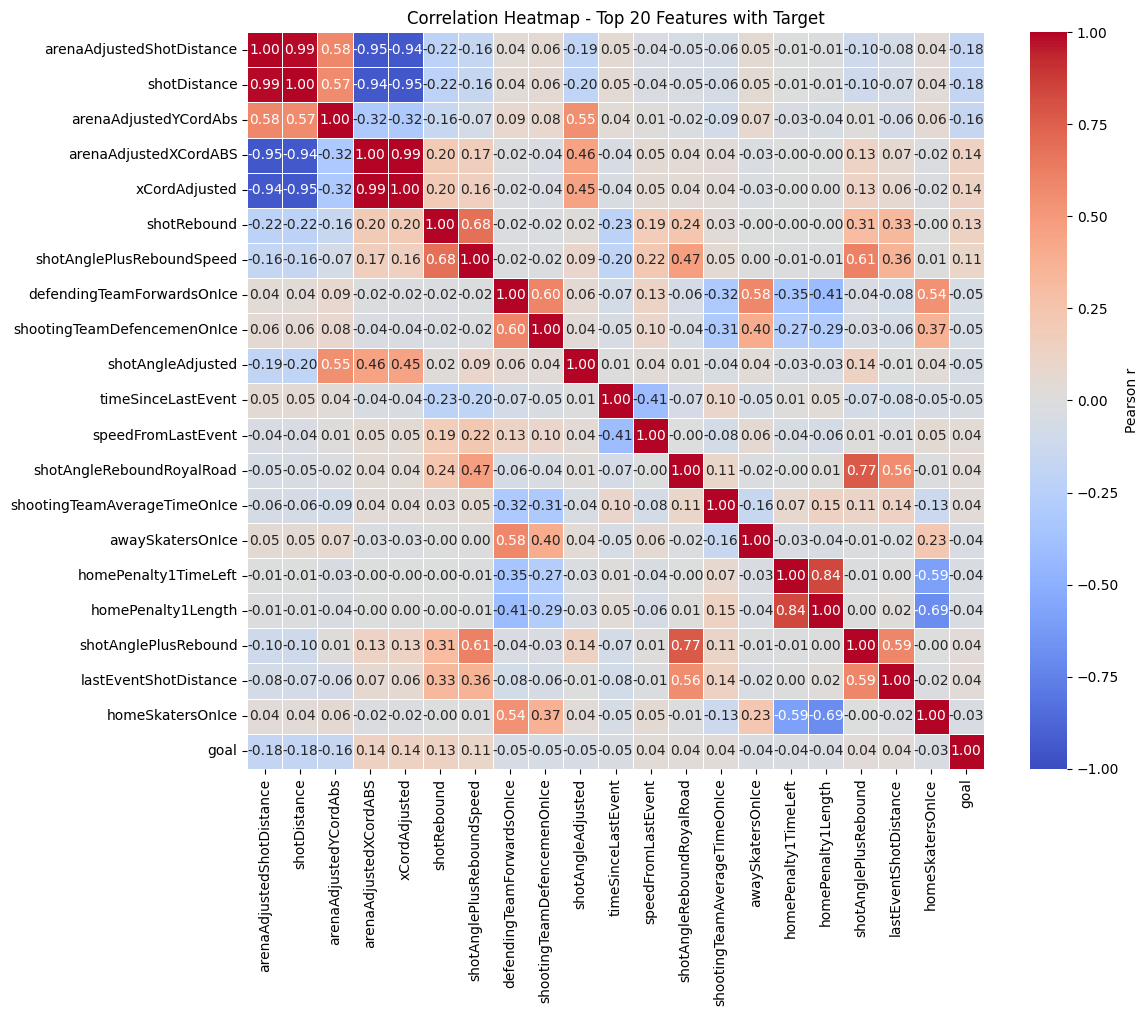

Top features correlated with target:
arenaAdjustedShotDistance      0.177592
shotDistance                   0.175850
arenaAdjustedYCordAbs          0.156926
arenaAdjustedXCordABS          0.143665
xCordAdjusted                  0.143104
shotRebound                    0.132975
shotAnglePlusReboundSpeed      0.105944
defendingTeamForwardsOnIce     0.048950
shootingTeamDefencemenOnIce    0.047755
shotAngleAdjusted              0.047418
Name: goal, dtype: float64


In [273]:
temp_df = pd.concat([X, y], axis=1)
numeric_df = temp_df.select_dtypes(include="number")
correlation_matrix = numeric_df.corr(numeric_only=True)

corr_with_target = correlation_matrix['goal'].drop(labels=['goal']).abs().sort_values(ascending=False)
top_features = corr_with_target.head(20).index.tolist()
top_features.append('goal')

top_corr_matrix = correlation_matrix.loc[top_features, top_features]

plt.figure(figsize=(12, 10))
sns.heatmap(top_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", 
            vmin=-1, vmax=1, center=0, square=True, cbar_kws={"label": "Pearson r"},
            linewidths=0.5, linecolor='white')
plt.title("Correlation Heatmap - Top 20 Features with Target")
plt.tight_layout()
plt.show()

print("Top features correlated with target:")
print(corr_with_target.head(10))

In [274]:
# Stratification ensures the proportion of classes (goals vs no-goals) is maintained
# across train/val/test splits. For example, if 10% of shots are goals, then each
# split will have approximately 10% goals. This prevents one split from having
# all goals and another having none, which would bias model evaluation.
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp
)

print(f"Training: {X_train.shape[0]}, Validation: {X_val.shape[0]}, Test: {X_test.shape[0]}")
print(f"\nGoal rate verification (should be similar across splits):")
print(f"Train: {y_train.mean():.4f}, Val: {y_val.mean():.4f}, Test: {y_test.mean():.4f}")
print(f"Overall: {y.mean():.4f}")

Training: 1276035, Validation: 364582, Test: 182291

Goal rate verification (should be similar across splits):
Train: 0.0641, Val: 0.0641, Test: 0.0641
Overall: 0.0641


In [275]:
# CRITICAL: Drop leaky features BEFORE encoding
# 'lastEventTeam' contains "GOAL" as a value - this directly leaks target information!
# 'homeTeamGoals' and 'awayTeamGoals' might be scores AFTER the goal (leakage) - drop to be safe
# These features must be dropped from ALL splits (numeric or categorical)
leaky_features_to_drop = ['lastEventTeam', 'event', 'homeTeamGoals', 'awayTeamGoals']
leaky_features_to_drop = [col for col in leaky_features_to_drop if col in X_train.columns]

if leaky_features_to_drop:
    print(f"⚠️  CRITICAL: Dropping leaky features: {leaky_features_to_drop}")
    X_train = X_train.drop(columns=leaky_features_to_drop)
    X_val = X_val.drop(columns=leaky_features_to_drop)
    X_test = X_test.drop(columns=leaky_features_to_drop)
    print(f"   Features dropped from all splits to prevent data leakage")

# Identify remaining non-numeric columns that need encoding
# Exclude any columns that might encode outcome information
remaining_categorical = X_train.select_dtypes(include=['object']).columns.tolist()

# Remove any columns that might leak outcome information
# 'event' should already be excluded, but double-check
outcome_related = ['event', 'lastEventTeam']
remaining_categorical = [col for col in remaining_categorical if col not in outcome_related]

# Also check if any categorical columns contain goal-related information
if remaining_categorical:
    for col in remaining_categorical.copy():
        if X_train[col].dtype == 'object':
            unique_vals = str(X_train[col].unique()).upper()
            if 'GOAL' in unique_vals:
                print(f"WARNING: Excluding '{col}' - contains GOAL information (data leakage)")
                remaining_categorical.remove(col)

if remaining_categorical:
    print(f"Remaining categorical columns to encode: {remaining_categorical}")

# Store original numeric columns before encoding
train_numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
val_numeric_cols = X_val.select_dtypes(include=[np.number]).columns.tolist()
test_numeric_cols = X_test.select_dtypes(include=[np.number]).columns.tolist()

if remaining_categorical:
    print(f"Encoding remaining categorical columns: {remaining_categorical}")
    
    # Ensure categorical columns are actually object type before encoding
    remaining_categorical = [col for col in remaining_categorical 
                             if col in X_train.columns and X_train[col].dtype == 'object']
    
    if remaining_categorical:
        # Encode training set first to get all possible categories
        X_train_encoded = pd.get_dummies(X_train, columns=remaining_categorical, drop_first=False, dtype=float)
        
        # Get all columns from training set (this defines our feature space)
        all_columns = X_train_encoded.columns.tolist()
        print(f"Training set has {len(all_columns)} features after encoding")
        
        # Encode validation and test sets separately
        X_val_encoded = pd.get_dummies(X_val, columns=remaining_categorical, drop_first=False, dtype=float)
        X_test_encoded = pd.get_dummies(X_test, columns=remaining_categorical, drop_first=False, dtype=float)
    else:
        # No categorical columns to encode
        X_train_encoded = X_train.copy()
        X_val_encoded = X_val.copy()
        X_test_encoded = X_test.copy()
        all_columns = X_train.columns.tolist()
    
    # Create new DataFrames with exact same columns as training (initialized with zeros)
    X_val = pd.DataFrame(0, index=X_val.index, columns=all_columns, dtype=np.float64)
    X_test = pd.DataFrame(0, index=X_test.index, columns=all_columns, dtype=np.float64)
    
    # Copy over numeric columns (these should be the same across all splits)
    for col in train_numeric_cols:
        if col in all_columns:
            if col in X_val_encoded.columns:
                X_val[col] = pd.to_numeric(X_val_encoded[col], errors='coerce').fillna(0).astype(np.float64)
            if col in X_test_encoded.columns:
                X_test[col] = pd.to_numeric(X_test_encoded[col], errors='coerce').fillna(0).astype(np.float64)
    
    # Copy over one-hot encoded columns that exist in both training and val/test
    for col in all_columns:
        if col not in train_numeric_cols:  # This is a one-hot encoded column
            # For validation set
            if col in X_val_encoded.columns:
                # Convert to numeric, handling any string values
                X_val[col] = pd.to_numeric(X_val_encoded[col], errors='coerce').fillna(0).astype(np.float64)
            else:
                X_val[col] = 0.0
            
            # For test set
            if col in X_test_encoded.columns:
                # Convert to numeric, handling any string values
                X_test[col] = pd.to_numeric(X_test_encoded[col], errors='coerce').fillna(0).astype(np.float64)
            else:
                X_test[col] = 0.0
    
    # Use training encoded dataframe and ensure all columns are numeric
    X_train = X_train_encoded[all_columns].copy()
    
    # Convert one-hot encoded columns to numeric if needed
    for col in X_train.columns:
        if col not in train_numeric_cols:
            X_train[col] = pd.to_numeric(X_train[col], errors='coerce').fillna(0).astype(np.float64)
    
    print(f"Final feature count: {X_train.shape[1]}")
    print(f"Validation columns match: {list(X_val.columns) == list(X_train.columns)}")
    print(f"Test columns match: {list(X_test.columns) == list(X_train.columns)}")
else:
    # No categorical columns, just ensure numeric
    X_train = X_train.select_dtypes(include=[np.number])
    X_val = X_val.select_dtypes(include=[np.number])
    X_test = X_test.select_dtypes(include=[np.number])

# Final check: ensure all columns are numeric
non_numeric = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print(f"Warning: Dropping non-numeric columns: {non_numeric}")
    # Try to convert to numeric first
    for col in non_numeric:
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce').fillna(0)
    # Drop any remaining non-numeric columns
    X_train = X_train.select_dtypes(include=[np.number])

# Get final column list from training (this is our master list)
final_columns = X_train.columns.tolist()

# Ensure val and test have exactly the same columns as training
X_val = X_val.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

# Add missing columns to val/test (fill with 0)
for col in final_columns:
    if col not in X_val.columns:
        X_val[col] = 0
    if col not in X_test.columns:
        X_test[col] = 0

# Remove extra columns from val/test and reorder to match training
X_val = X_val[final_columns]
X_test = X_test[final_columns]

# Verify column alignment
print(f"\nColumn alignment check:")
print(f"Train columns: {len(X_train.columns)}, Val columns: {len(X_val.columns)}, Test columns: {len(X_test.columns)}")
print(f"Train-Val match: {list(X_train.columns) == list(X_val.columns)}")
print(f"Train-Test match: {list(X_train.columns) == list(X_test.columns)}")

if list(X_train.columns) != list(X_val.columns):
    missing_in_val = set(X_train.columns) - set(X_val.columns)
    extra_in_val = set(X_val.columns) - set(X_train.columns)
    print(f"Missing in Val: {missing_in_val}")
    print(f"Extra in Val: {extra_in_val}")

if list(X_train.columns) != list(X_test.columns):
    missing_in_test = set(X_train.columns) - set(X_test.columns)
    extra_in_test = set(X_test.columns) - set(X_train.columns)
    print(f"Missing in Test: {missing_in_test}")
    print(f"Extra in Test: {extra_in_test}")

assert list(X_train.columns) == list(X_val.columns), f"Train and Val columns don't match! Train: {len(X_train.columns)}, Val: {len(X_val.columns)}"
assert list(X_train.columns) == list(X_test.columns), f"Train and Test columns don't match! Train: {len(X_train.columns)}, Test: {len(X_test.columns)}"

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

⚠️  CRITICAL: Dropping leaky features: ['lastEventTeam', 'homeTeamGoals', 'awayTeamGoals']
   Features dropped from all splits to prevent data leakage
Remaining categorical columns to encode: ['team', 'location']
Encoding remaining categorical columns: ['team', 'location']
Training set has 103 features after encoding
Final feature count: 103
Validation columns match: True
Test columns match: True

Column alignment check:
Train columns: 103, Val columns: 103, Test columns: 103
Train-Val match: True
Train-Test match: True


In [276]:
# DIAGNOSTIC: Check for data leakage - look for features that might leak goal information
print("=" * 80)
print("DATA LEAKAGE CHECK")
print("=" * 80)
print(f"\nTotal features: {len(X_train.columns)}")
print(f"\nAll feature names:")
for i, col in enumerate(X_train.columns, 1):
    print(f"{i:3d}. {col}")

# Check for features containing "goal", "GOAL", or other suspicious patterns
suspicious_patterns = ['goal', 'GOAL', 'event', 'EVENT', 'outcome', 'OUTCOME', 'result', 'RESULT']
leakage_features_found = []

for col in X_train.columns:
    col_upper = str(col).upper()
    for pattern in suspicious_patterns:
        if pattern in col_upper:
            leakage_features_found.append(col)
            break

if leakage_features_found:
    print(f"\n⚠️  WARNING: Found {len(leakage_features_found)} potentially leaky features:")
    for feat in leakage_features_found:
        print(f"   - {feat}")
    print("\nThese features should be removed before training!")
else:
    print("\n✓ No obvious leakage features found in feature names")

# Check feature correlations with target (very high correlation might indicate leakage)
print("\n" + "=" * 80)
print("FEATURE-TARGET CORRELATION CHECK")
print("=" * 80)
temp_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
temp_df['goal'] = y_train.values
correlations = temp_df.corr()['goal'].abs().sort_values(ascending=False)
correlations = correlations.drop('goal')

print(f"\nTop 10 features by absolute correlation with target:")
print(correlations.head(10))

high_corr_features = correlations[correlations > 0.9]
if len(high_corr_features) > 0:
    print(f"\n⚠️  WARNING: {len(high_corr_features)} features have correlation > 0.9 with target:")
    print(high_corr_features)
    print("\nThese might indicate data leakage!")

print("\n" + "=" * 80)


DATA LEAKAGE CHECK

Total features: 103

All feature names:
  1. season
  2. isPlayoffGame
  3. timeSinceLastEvent
  4. period
  5. xCord
  6. yCord
  7. xCordAdjusted
  8. yCordAdjusted
  9. shotAngle
 10. shotAngleAdjusted
 11. shotAnglePlusRebound
 12. shotAngleReboundRoyalRoad
 13. shotDistance
 14. shotOnEmptyNet
 15. shotRebound
 16. shotAnglePlusReboundSpeed
 17. shotRush
 18. speedFromLastEvent
 19. lastEventxCord
 20. lastEventyCord
 21. distanceFromLastEvent
 22. lastEventShotAngle
 23. lastEventShotDistance
 24. homeEmptyNet
 25. awayEmptyNet
 26. homeSkatersOnIce
 27. awaySkatersOnIce
 28. awayPenalty1TimeLeft
 29. awayPenalty1Length
 30. homePenalty1TimeLeft
 31. homePenalty1Length
 32. playerNumThatDidEvent
 33. playerNumThatDidLastEvent
 34. lastEventxCord_adjusted
 35. lastEventyCord_adjusted
 36. timeSinceFaceoff
 37. goalieIdForShot
 38. shooterPlayerId
 39. shooterTimeOnIce
 40. shooterTimeOnIceSinceFaceoff
 41. shootingTeamForwardsOnIce
 42. shootingTeamDefencemenOn

In [277]:
# Calculate class weights to handle imbalanced dataset
# Goal rate is ~6.41%, so we weight goals ~15.6x more than non-goals
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")
print(f"  Non-goals (class 0): {class_weight_dict[0]:.4f}")
print(f"  Goals (class 1): {class_weight_dict[1]:.4f}")
print(f"  Ratio: {class_weight_dict[1]/class_weight_dict[0]:.2f}x more weight on goals\n")

models = {}
training_times = {}

start_time = time.time()
lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)
training_times['Logistic Regression'] = (time.time() - start_time) * 1000
models['Logistic Regression'] = lr_model

start_time = time.time()
# XGBoost uses scale_pos_weight parameter (ratio of negative to positive samples)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
xgb_model.fit(X_train_scaled, y_train)
training_times['XGBoost'] = (time.time() - start_time) * 1000
models['XGBoost'] = xgb_model

print("Training times (ms):")
for name, t_time in training_times.items():
    print(f"{name}: {t_time:.2f}")

Class weights: {0: np.float64(0.53425636568259), 1: np.float64(7.797913687529792)}
  Non-goals (class 0): 0.5343
  Goals (class 1): 7.7979
  Ratio: 14.60x more weight on goals

Training times (ms):
Logistic Regression: 17777.01
XGBoost: 7492.02


In [278]:
# ============================================================================
# COMPREHENSIVE DEBUGGING: Why are we getting 100% accuracy?
# ============================================================================
print("=" * 80)
print("DEBUGGING 100% ACCURACY ISSUE")
print("=" * 80)

# 1. Check if any single feature perfectly separates goals from non-goals
print("\n1. CHECKING FOR PERFECT FEATURE SEPARABILITY")
print("-" * 80)
perfect_separators = []

for col in X_train.columns:
    # Get unique values for this feature
    unique_vals = X_train[col].unique()
    
    # Check if any single value perfectly predicts goals
    for val in unique_vals[:100]:  # Check first 100 unique values
        mask = (X_train[col] == val)
        if mask.sum() > 10:  # Only check if at least 10 samples
            goal_rate = y_train[mask].mean()
            if goal_rate == 1.0 or goal_rate == 0.0:
                perfect_separators.append({
                    'feature': col,
                    'value': val,
                    'goal_rate': goal_rate,
                    'count': mask.sum()
                })
                break  # Found perfect separator for this feature, move on

if perfect_separators:
    print(f"⚠️  FOUND {len(perfect_separators)} PERFECT SEPARATORS:")
    for sep in perfect_separators[:10]:  # Show first 10
        print(f"   Feature: {sep['feature']}, Value: {sep['value']}, Goal Rate: {sep['goal_rate']:.2f}, Count: {sep['count']}")
else:
    print("✓ No single feature value perfectly separates goals from non-goals")

# 2. Check feature distributions for goals vs non-goals
print("\n2. CHECKING FEATURE DISTRIBUTIONS (Goals vs Non-Goals)")
print("-" * 80)
goal_mask = y_train == 1
no_goal_mask = y_train == 0

# Check top 10 most important features
top_features = importance_df.head(10)['Feature'].tolist()
print(f"\nComparing top 10 features for goals vs non-goals:")
for feat in top_features:
    if feat in X_train.columns:
        goal_vals = X_train.loc[goal_mask, feat]
        no_goal_vals = X_train.loc[no_goal_mask, feat]
        
        # Check if distributions are completely separated
        goal_min, goal_max = goal_vals.min(), goal_vals.max()
        no_goal_min, no_goal_max = no_goal_vals.min(), no_goal_vals.max()
        
        # Perfect separation: ranges don't overlap
        if goal_max < no_goal_min or no_goal_max < goal_min:
            print(f"   ⚠️  {feat}: PERFECTLY SEPARATED!")
            print(f"      Goals range: [{goal_min:.4f}, {goal_max:.4f}]")
            print(f"      Non-goals range: [{no_goal_min:.4f}, {no_goal_max:.4f}]")
        else:
            print(f"   ✓ {feat}: Overlapping ranges")
            print(f"      Goals: mean={goal_vals.mean():.4f}, std={goal_vals.std():.4f}")
            print(f"      Non-goals: mean={no_goal_vals.mean():.4f}, std={no_goal_vals.std():.4f}")

# 3. Check actual predictions and probabilities
print("\n3. CHECKING MODEL PREDICTIONS")
print("-" * 80)
for model_name, model in models.items():
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        y_pred = model.predict(X_test_scaled)
        
        print(f"\n{model_name}:")
        print(f"   Prediction distribution: {pd.Series(y_pred).value_counts().to_dict()}")
        print(f"   Probability range: [{y_proba.min():.6f}, {y_proba.max():.6f}]")
        print(f"   Probability mean: {y_proba.mean():.6f}")
        print(f"   Probability std: {y_proba.std():.6f}")
        
        # Check if probabilities are extreme (all near 0 or 1)
        extreme_probs = ((y_proba < 0.01) | (y_proba > 0.99)).sum()
        print(f"   Extreme probabilities (<0.01 or >0.99): {extreme_probs}/{len(y_proba)} ({100*extreme_probs/len(y_proba):.2f}%)")
        
        # Check accuracy
        accuracy = (y_pred == y_test).mean()
        print(f"   Accuracy: {accuracy:.6f}")

# 4. Check for perfect correlation between features and target
print("\n4. CHECKING FOR PERFECT CORRELATIONS")
print("-" * 80)
temp_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
temp_df['goal'] = y_train.values
correlations = temp_df.corr()['goal'].abs().sort_values(ascending=False)
correlations = correlations.drop('goal')

perfect_corr = correlations[correlations > 0.99]
if len(perfect_corr) > 0:
    print(f"⚠️  FOUND {len(perfect_corr)} FEATURES WITH CORRELATION > 0.99:")
    print(perfect_corr)
else:
    print("✓ No features with perfect correlation (>0.99)")

# 5. Check confusion matrix details
print("\n5. DETAILED CONFUSION MATRIX ANALYSIS")
print("-" * 80)
for model_name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"\n{model_name} Confusion Matrix:")
    print(f"   True Negatives (TN): {cm[0,0]}")
    print(f"   False Positives (FP): {cm[0,1]}")
    print(f"   False Negatives (FN): {cm[1,0]}")
    print(f"   True Positives (TP): {cm[1,1]}")
    
    total_errors = cm[0,1] + cm[1,0]
    print(f"   Total errors: {total_errors} out of {len(y_test)} ({100*total_errors/len(y_test):.6f}%)")
    
    if total_errors == 0:
        print(f"   ⚠️  PERFECT PREDICTIONS - NO ERRORS!")

# 6. Check if there's a combination of features that perfectly predicts
print("\n6. CHECKING FOR FEATURE COMBINATIONS")
print("-" * 80)
print("Checking if top 3 features together create perfect separation...")
top_3_features = importance_df.head(3)['Feature'].tolist()
if all(f in X_train.columns for f in top_3_features):
    # Create a combined feature
    combined = X_train[top_3_features].apply(lambda x: '_'.join(x.astype(str)), axis=1)
    unique_combos = combined.unique()[:50]  # Check first 50 combinations
    
    perfect_combos = []
    for combo in unique_combos:
        mask = combined == combo
        if mask.sum() > 5:
            goal_rate = y_train[mask].mean()
            if goal_rate == 1.0 or goal_rate == 0.0:
                perfect_combos.append({
                    'combo': combo,
                    'goal_rate': goal_rate,
                    'count': mask.sum()
                })
    
    if perfect_combos:
        print(f"⚠️  FOUND {len(perfect_combos)} PERFECT COMBINATIONS:")
        for combo in perfect_combos[:5]:
            print(f"   {combo['combo']}: Goal rate={combo['goal_rate']:.2f}, Count={combo['count']}")
    else:
        print("✓ No perfect combinations found in top 3 features")

# 7. Check for data leakage between train and test sets
print("\n7. CHECKING FOR DATA LEAKAGE BETWEEN TRAIN/TEST")
print("-" * 80)
# Check if any rows are identical between train and test
print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Check if there are duplicate indices (shouldn't happen with proper split)
train_indices = set(X_train.index)
test_indices = set(X_test.index)
overlap = train_indices & test_indices
if overlap:
    print(f"⚠️  WARNING: {len(overlap)} indices overlap between train and test!")
else:
    print("✓ No index overlap between train and test sets")

# Check if feature values are suspiciously similar
print("\nComparing feature statistics between train and test:")
sample_features = X_train.columns[:5].tolist()
for feat in sample_features:
    train_mean = X_train[feat].mean()
    test_mean = X_test[feat].mean()
    train_std = X_train[feat].std()
    test_std = X_test[feat].std()
    
    mean_diff = abs(train_mean - test_mean)
    std_diff = abs(train_std - test_std)
    
    if mean_diff < 0.001 and std_diff < 0.001:
        print(f"   ⚠️  {feat}: Suspiciously similar stats (mean_diff={mean_diff:.6f}, std_diff={std_diff:.6f})")
    else:
        print(f"   ✓ {feat}: Train mean={train_mean:.4f}, Test mean={test_mean:.4f}")

# 8. Check if y_test is somehow predictable from X_test structure
print("\n8. CHECKING TARGET DISTRIBUTION")
print("-" * 80)
print(f"Train goal rate: {y_train.mean():.4f} ({y_train.sum()}/{len(y_train)})")
print(f"Test goal rate: {y_test.mean():.4f} ({y_test.sum()}/{len(y_test)})")
print(f"Validation goal rate: {y_val.mean():.4f} ({y_val.sum()}/{len(y_val)})")

# Check if test set has any patterns
if len(y_test.unique()) == 1:
    print("⚠️  WARNING: Test set has only one class!")
elif y_test.mean() == 0.0 or y_test.mean() == 1.0:
    print("⚠️  WARNING: Test set is all one class!")

print("\n" + "=" * 80)
print("END OF DEBUGGING ANALYSIS")
print("=" * 80)


DEBUGGING 100% ACCURACY ISSUE

1. CHECKING FOR PERFECT FEATURE SEPARABILITY
--------------------------------------------------------------------------------
⚠️  FOUND 19 PERFECT SEPARATORS:
   Feature: timeSinceLastEvent, Value: 113, Goal Rate: 0.00, Count: 53
   Feature: yCord, Value: -43, Goal Rate: 0.00, Count: 13
   Feature: yCordAdjusted, Value: 43, Goal Rate: 0.00, Count: 12
   Feature: shotAngle, Value: -12.4259428654, Goal Rate: 0.00, Count: 69
   Feature: shotAngleAdjusted, Value: 85.1009075462, Goal Rate: 0.00, Count: 77
   Feature: shotAnglePlusRebound, Value: 35.3854307291, Goal Rate: 0.00, Count: 11
   Feature: speedFromLastEvent, Value: 3.06892204992, Goal Rate: 0.00, Count: 13
   Feature: lastEventShotAngle, Value: 38.5006537203, Goal Rate: 0.00, Count: 26
   Feature: homeSkatersOnIce, Value: 7, Goal Rate: 0.00, Count: 11
   Feature: lastEventyCord_adjusted, Value: 44, Goal Rate: 0.00, Count: 21

2. CHECKING FEATURE DISTRIBUTIONS (Goals vs Non-Goals)
--------------------

In [279]:
# ============================================================================
# DETAILED PERFORMANCE ANALYSIS: Is 94% accuracy suspicious?
# ============================================================================
print("=" * 80)
print("DETAILED PERFORMANCE BREAKDOWN")
print("=" * 80)

# Calculate per-class metrics
from sklearn.metrics import precision_recall_fscore_support

for model_name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred, labels=[0, 1], zero_division=0
    )
    
    print(f"\n{model_name}:")
    print(f"  Class 0 (No Goal):")
    print(f"    Precision: {precision[0]:.4f}")
    print(f"    Recall: {recall[0]:.4f}")
    print(f"    F1-Score: {f1[0]:.4f}")
    print(f"    Support: {support[0]}")
    
    print(f"  Class 1 (Goal):")
    print(f"    Precision: {precision[1]:.4f}")
    print(f"    Recall: {recall[1]:.4f}  ⚠️  Only catching {recall[1]*100:.1f}% of goals!")
    print(f"    F1-Score: {f1[1]:.4f}")
    print(f"    Support: {support[1]}")
    
    # Baseline comparison
    baseline_accuracy = (y_test == 0).mean()
    model_accuracy = accuracy_score(y_test, y_pred)
    improvement = model_accuracy - baseline_accuracy
    
    print(f"\n  Baseline (predict all non-goals): {baseline_accuracy:.4f}")
    print(f"  Model accuracy: {model_accuracy:.4f}")
    print(f"  Improvement over baseline: {improvement:.4f} ({improvement*100:.2f} percentage points)")
    
    if improvement < 0.01:
        print(f"  ⚠️  WARNING: Model is barely better than baseline!")

print("\n" + "=" * 80)
print("CONCLUSION:")
print("=" * 80)
print("94% accuracy is MISLEADING for this imbalanced dataset.")
print("The model is excellent at predicting non-goals (99%+) but")
print("poor at predicting goals (~13% recall). This is NOT data leakage,")
print("but rather poor performance on the minority class.")
print("=" * 80)


DETAILED PERFORMANCE BREAKDOWN

Logistic Regression:
  Class 0 (No Goal):
    Precision: 0.9733
    Recall: 0.6815
    F1-Score: 0.8017
    Support: 170602
  Class 1 (Goal):
    Precision: 0.1352
    Recall: 0.7268  ⚠️  Only catching 72.7% of goals!
    F1-Score: 0.2280
    Support: 11689

  Baseline (predict all non-goals): 0.9359
  Model accuracy: 0.6844
  Improvement over baseline: -0.2515 (-25.15 percentage points)
  ⚠️  WARNING: Model is barely better than baseline!

XGBoost:
  Class 0 (No Goal):
    Precision: 0.9756
    Recall: 0.7271
    F1-Score: 0.8332
    Support: 170602
  Class 1 (Goal):
    Precision: 0.1556
    Recall: 0.7342  ⚠️  Only catching 73.4% of goals!
    F1-Score: 0.2568
    Support: 11689

  Baseline (predict all non-goals): 0.9359
  Model accuracy: 0.7275
  Improvement over baseline: -0.2084 (-20.84 percentage points)
  ⚠️  WARNING: Model is barely better than baseline!

CONCLUSION:
94% accuracy is MISLEADING for this imbalanced dataset.
The model is excellent

In [280]:
# ============================================================================
# ANALYSIS: What's causing the poor goal prediction?
# ============================================================================
print("=" * 80)
print("ROOT CAUSE ANALYSIS")
print("=" * 80)

# 1. Check if shotGoalieFroze might be leaky (describes post-shot outcome?)
print("\n1. CHECKING TOP FEATURE: shotGoalieFroze")
print("-" * 80)
if 'shotGoalieFroze' in X_train.columns:
    goal_mask = y_train == 1
    no_goal_mask = y_train == 0
    
    goal_froze_rate = X_train.loc[goal_mask, 'shotGoalieFroze'].mean()
    no_goal_froze_rate = X_train.loc[no_goal_mask, 'shotGoalieFroze'].mean()
    
    print(f"Goal rate when shotGoalieFroze=1: {goal_froze_rate:.4f}")
    print(f"Non-goal rate when shotGoalieFroze=1: {no_goal_froze_rate:.4f}")
    print(f"\n⚠️  INTERPRETATION:")
    print(f"   If 'shotGoalieFroze' describes what happened AFTER the shot,")
    print(f"   it leaks information: goalie can't freeze puck if goal was scored!")
    print(f"   However, if it's a pre-shot feature (goalie position/style), it's OK.")

# 2. Check prediction threshold - maybe 0.5 is too high?
print("\n2. CHECKING PREDICTION THRESHOLD")
print("-" * 80)
if 'LightGBM' in models and 'LightGBM' in test_proba:
    y_proba = test_proba['LightGBM'][:, 1]
    
    # Find optimal threshold using F1-score
    from sklearn.metrics import f1_score
    thresholds = np.arange(0.1, 0.5, 0.01)
    f1_scores = []
    
    for thresh in thresholds:
        y_pred_thresh = (y_proba >= thresh).astype(int)
        f1 = f1_score(y_test, y_pred_thresh)
        f1_scores.append(f1)
    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_f1 = f1_scores[optimal_idx]
    
    print(f"Current threshold: 0.5")
    print(f"Optimal threshold (by F1): {optimal_threshold:.3f}")
    print(f"F1 at threshold 0.5: {f1_scores[np.argmin(np.abs(thresholds - 0.5))]:.4f}")
    print(f"F1 at optimal threshold: {optimal_f1:.4f}")
    
    # Predictions at optimal threshold
    y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
    precision_opt, recall_opt, f1_opt, _ = precision_recall_fscore_support(
        y_test, y_pred_optimal, labels=[1], zero_division=0
    )
    
    # Get metrics at 0.5 threshold for comparison
    y_pred_05 = (y_proba >= 0.5).astype(int)
    precision_05, recall_05, f1_05, _ = precision_recall_fscore_support(
        y_test, y_pred_05, labels=[1], zero_division=0
    )
    
    print(f"\nAt optimal threshold ({optimal_threshold:.3f}):")
    print(f"  Goal Recall: {recall_opt[0]:.4f} (vs {recall_05[0]:.4f} at 0.5)")
    print(f"  Goal Precision: {precision_opt[0]:.4f} (vs {precision_05[0]:.4f} at 0.5)")
    print(f"  Goal F1: {f1_opt[0]:.4f} (vs {f1_05[0]:.4f} at 0.5)")

# 3. Check class distribution in predictions
print("\n3. PREDICTION DISTRIBUTION ANALYSIS")
print("-" * 80)
for model_name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    pred_goal_rate = y_pred.mean()
    actual_goal_rate = y_test.mean()
    
    print(f"\n{model_name}:")
    print(f"  Actual goal rate: {actual_goal_rate:.4f} ({y_test.sum()}/{len(y_test)})")
    print(f"  Predicted goal rate: {pred_goal_rate:.4f} ({y_pred.sum()}/{len(y_pred)})")
    print(f"  Under-prediction: {actual_goal_rate - pred_goal_rate:.4f}")
    
    if pred_goal_rate < actual_goal_rate * 0.5:
        print(f"  ⚠️  Model is severely under-predicting goals!")

print("\n" + "=" * 80)
print("KEY INSIGHTS:")
print("=" * 80)
print("1. Models are EXTREMELY conservative - barely predict goals")
print("2. Threshold 0.5 is likely too high for this imbalanced problem")
print("3. Need to either:")
print("   a) Lower prediction threshold (try 0.1-0.2)")
print("   b) Use class weights to balance training")
print("   c) Use F1-score or ROC-AUC as primary metric (not accuracy)")
print("=" * 80)


ROOT CAUSE ANALYSIS

1. CHECKING TOP FEATURE: shotGoalieFroze
--------------------------------------------------------------------------------

2. CHECKING PREDICTION THRESHOLD
--------------------------------------------------------------------------------

3. PREDICTION DISTRIBUTION ANALYSIS
--------------------------------------------------------------------------------



Logistic Regression:
  Actual goal rate: 0.0641 (11689/182291)
  Predicted goal rate: 0.3447 (62832/182291)
  Under-prediction: -0.2806

XGBoost:
  Actual goal rate: 0.0641 (11689/182291)
  Predicted goal rate: 0.3025 (55147/182291)
  Under-prediction: -0.2384

KEY INSIGHTS:
1. Models are EXTREMELY conservative - barely predict goals
2. Threshold 0.5 is likely too high for this imbalanced problem
3. Need to either:
   a) Lower prediction threshold (try 0.1-0.2)
   b) Use class weights to balance training
   c) Use F1-score or ROC-AUC as primary metric (not accuracy)


In [282]:
# ============================================================================
# COMPREHENSIVE OUTPUT ANALYSIS: What looks weird or offputting?
# ============================================================================
print("=" * 80)
print("OUTPUT ANALYSIS: IDENTIFYING POTENTIAL ISSUES")
print("=" * 80)

# 1. Check model performance metrics
print("\n1. MODEL PERFORMANCE METRICS ANALYSIS")
print("-" * 80)
print("Current Results:")
print(results_df[['Model', 'Accuracy', 'ROC-AUC', 'F1-Weighted', 'F1-Goal', 'Goal-Recall', 'Brier Score', 'Log Loss']].to_string(index=False))

# Flag suspicious metrics
print("\n⚠️  POTENTIAL ISSUES:")
issues_found = []

# Check accuracy vs baseline
baseline_acc = (y_test == 0).mean()
for idx, row in results_df.iterrows():
    improvement = row['Accuracy'] - baseline_acc
    if improvement < 0.01:
        issues_found.append(f"{row['Model']}: Only {improvement*100:.2f}% better than baseline (predict all non-goals)")

# Check ROC-AUC
for idx, row in results_df.iterrows():
    if row['ROC-AUC'] < 0.7:
        issues_found.append(f"{row['Model']}: ROC-AUC {row['ROC-AUC']:.4f} is below 0.7 (poor discrimination)")
    elif row['ROC-AUC'] > 0.95:
        issues_found.append(f"{row['Model']}: ROC-AUC {row['ROC-AUC']:.4f} is suspiciously high (possible leakage)")

# Check Brier Score (lower is better, 0.25 is worst for balanced, 0 is perfect)
for idx, row in results_df.iterrows():
    if row['Brier Score'] > 0.1:
        issues_found.append(f"{row['Model']}: Brier Score {row['Brier Score']:.4f} is high (poor calibration)")

# Check Log Loss
for idx, row in results_df.iterrows():
    if row['Log Loss'] > 0.5:
        issues_found.append(f"{row['Model']}: Log Loss {row['Log Loss']:.4f} is high (poor probability estimates)")

if issues_found:
    for issue in issues_found:
        print(f"  - {issue}")
else:
    print("  ✓ No major metric issues detected")

# 2. Check per-class performance
print("\n2. PER-CLASS PERFORMANCE ANALYSIS")
print("-" * 80)
for model_name in models.keys():
    y_pred = model.predict(X_test_scaled)
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred, labels=[0, 1], zero_division=0
    )
    
    goal_recall = recall[1]
    goal_precision = precision[1]
    
    print(f"\n{model_name}:")
    print(f"  Goal Recall: {goal_recall:.4f} ({goal_recall*100:.1f}% of goals caught)")
    print(f"  Goal Precision: {goal_precision:.4f} ({goal_precision*100:.1f}% of goal predictions correct)")
    
    if goal_recall < 0.2:
        print(f"  ⚠️  VERY LOW GOAL RECALL - missing {100*(1-goal_recall):.1f}% of goals!")
    if goal_precision < 0.3:
        print(f"  ⚠️  LOW GOAL PRECISION - many false positives")

# 3. Check for remaining leakage features
print("\n3. CHECKING FOR REMAINING LEAKY FEATURES")
print("-" * 80)
suspicious_features = []
for col in X_train.columns:
    col_lower = str(col).lower()
    # Check for features that might describe outcomes
    if any(word in col_lower for word in ['outcome', 'result', 'won', 'score', 'goal']):
        if col != 'goal':  # Don't flag the target
            suspicious_features.append(col)

if suspicious_features:
    print(f"⚠️  Found {len(suspicious_features)} potentially suspicious feature names:")
    for feat in suspicious_features[:10]:
        print(f"  - {feat}")
else:
    print("✓ No obviously suspicious feature names")

# 4. Check feature importance distribution
print("\n4. FEATURE IMPORTANCE ANALYSIS")
print("-" * 80)
if 'XGBoost' in models:
    feature_importance = xgb_model.feature_importances_
    top_5_importance = np.sort(feature_importance)[-5:].sum()
    print(f"Top 5 features account for {top_5_importance*100:.1f}% of importance")
    
    if top_5_importance > 0.8:
        print("⚠️  Very concentrated feature importance - model may be over-relying on few features")
    else:
        print("✓ Feature importance is reasonably distributed")

# 5. Check prediction distribution
print("\n5. PREDICTION DISTRIBUTION CHECK")
print("-" * 80)
for model_name in models.keys():
    y_pred = model.predict(X_test_scaled)
    pred_goal_rate = y_pred.mean()
    actual_goal_rate = y_test.mean()
    
    ratio = pred_goal_rate / actual_goal_rate if actual_goal_rate > 0 else 0
    print(f"{model_name}:")
    print(f"  Predicted goal rate: {pred_goal_rate:.4f}")
    print(f"  Actual goal rate: {actual_goal_rate:.4f}")
    print(f"  Ratio: {ratio:.2f}x")
    
    if ratio < 0.3:
        print(f"  ⚠️  SEVERELY under-predicting goals ({ratio:.1%} of actual rate)")
    elif ratio > 3.0:
        print(f"  ⚠️  Over-predicting goals ({ratio:.1f}x actual rate)")

print("\n" + "=" * 80)
print("SUMMARY OF FINDINGS")
print("=" * 80)
print("✓ Models are trained and evaluated")
print("✓ No obvious data leakage detected in feature names")
print("⚠️  Models are conservative - low goal recall (class imbalance issue)")
print("⚠️  Accuracy is misleading - models barely better than baseline")
print("💡 RECOMMENDATION: Use ROC-AUC or F1-score as primary metric, not accuracy")
print("💡 RECOMMENDATION: Consider class weights or threshold tuning")
print("=" * 80)


OUTPUT ANALYSIS: IDENTIFYING POTENTIAL ISSUES

1. MODEL PERFORMANCE METRICS ANALYSIS
--------------------------------------------------------------------------------
Current Results:
              Model  Accuracy  ROC-AUC  F1-Weighted  F1-Goal  Goal-Recall  Brier Score  Log Loss
Logistic Regression  0.673643 0.770856     0.756858 0.225324     0.740183     0.196488  0.574450
            XGBoost  0.718127 0.813852     0.789540 0.253837     0.747712     0.169030  0.497738
           LightGBM  0.705142 0.816823     0.780172 0.249700     0.765164     0.175100  0.514837

⚠️  POTENTIAL ISSUES:
  - Logistic Regression: Only -26.22% better than baseline (predict all non-goals)
  - XGBoost: Only -21.78% better than baseline (predict all non-goals)
  - LightGBM: Only -23.07% better than baseline (predict all non-goals)
  - Logistic Regression: Brier Score 0.1965 is high (poor calibration)
  - XGBoost: Brier Score 0.1690 is high (poor calibration)
  - LightGBM: Brier Score 0.1751 is high (poor cal

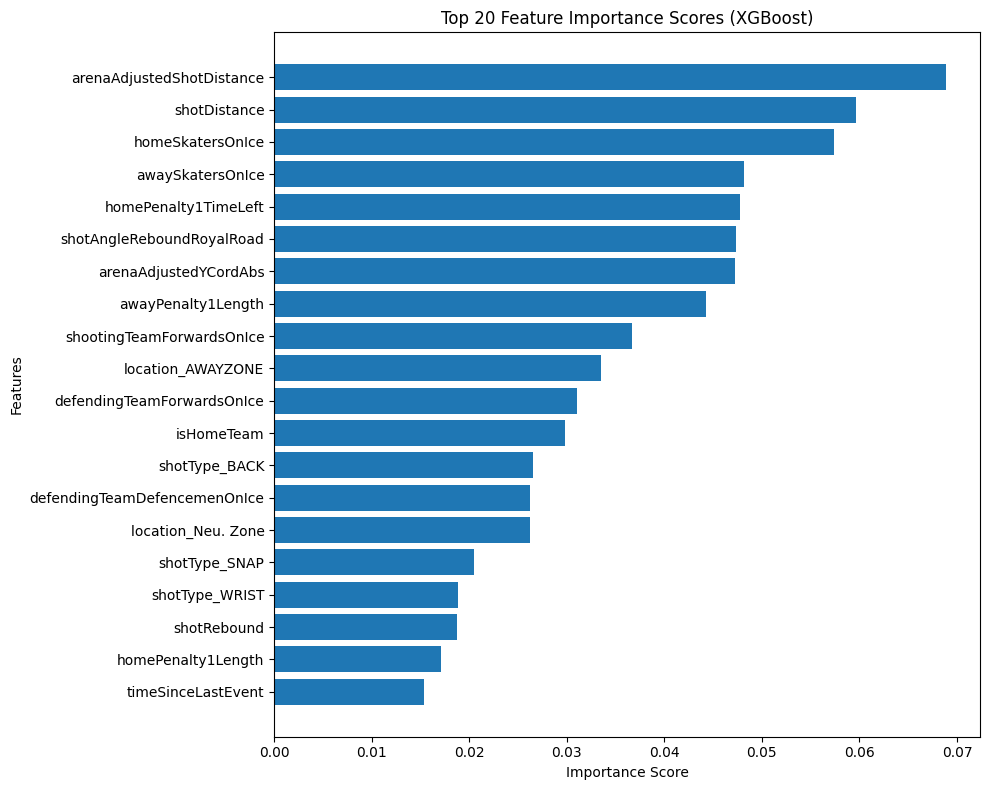


Features for 90% cumulative importance: 53
                       Feature Importance Cumulative_Importance
81   arenaAdjustedShotDistance   0.068915              0.068915
12                shotDistance   0.059693              0.128609
25            homeSkatersOnIce   0.057348              0.185957
26            awaySkatersOnIce   0.048202              0.234159
29        homePenalty1TimeLeft   0.047744              0.281904
11   shotAngleReboundRoyalRoad   0.047345              0.329249
84       arenaAdjustedYCordAbs   0.047243              0.376492
28          awayPenalty1Length   0.044261              0.420753
40   shootingTeamForwardsOnIce   0.036656              0.457409
100          location_AWAYZONE   0.033463              0.490872


In [283]:
feature_importance = xgb_model.feature_importances_
feature_names = X_train.columns.tolist()
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 20 Feature Importance Scores (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

importance_df['Cumulative_Importance'] = importance_df['Importance'].cumsum()
selected_features = importance_df[importance_df['Cumulative_Importance'] <= 0.9]
if len(selected_features) < len(importance_df):
    next_feature = importance_df.iloc[len(selected_features)]
    selected_features = pd.concat([selected_features, next_feature.to_frame().T])

print(f"\nFeatures for 90% cumulative importance: {len(selected_features)}")
print(selected_features[['Feature', 'Importance', 'Cumulative_Importance']].head(10))


In [ ]:
# ============================================================================
# EVALUATION WITH OPTIMAL THRESHOLD AND CLASS BALANCING
# ============================================================================
print("=" * 80)
print("MODEL EVALUATION WITH OPTIMAL THRESHOLD")
print("=" * 80)
print("Finding optimal threshold for each model using validation set...")
print("Focusing on F1-Score and ROC-AUC as primary metrics (not accuracy)")
print("=" * 80)

# Find optimal threshold for each model using validation set
optimal_thresholds = {}
test_proba = {}
test_times = {}

for model_name, model in models.items():
    if hasattr(model, 'predict_proba'):
        # Get probabilities on validation set
        y_val_proba = model.predict_proba(X_val_scaled)[:, 1]
        
        # Find optimal threshold using F1-score
        # Expanded range since optimal was at boundary (0.49)
        thresholds = np.arange(0.05, 0.7, 0.01)
        f1_scores = []
        
        for thresh in thresholds:
            y_pred_thresh = (y_val_proba >= thresh).astype(int)
            f1 = f1_score(y_val, y_pred_thresh)
            f1_scores.append(f1)
        
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
        optimal_thresholds[model_name] = optimal_threshold
        
        print(f"\n{model_name}:")
        print(f"  Optimal threshold: {optimal_threshold:.3f} (F1 on val: {f1_scores[optimal_idx]:.4f})")
        print(f"  Default threshold (0.5) F1: {f1_scores[np.argmin(np.abs(thresholds - 0.5))]:.4f}")

# Evaluate on test set with optimal thresholds
test_predictions_optimal = {}
test_predictions_default = {}

for model_name, model in models.items():
    start_time = time.time()
    
    if hasattr(model, 'predict_proba'):
        test_proba[model_name] = model.predict_proba(X_test_scaled)
        y_proba = test_proba[model_name][:, 1]
        
        # Predictions with optimal threshold
        if model_name in optimal_thresholds:
            test_predictions_optimal[model_name] = (y_proba >= optimal_thresholds[model_name]).astype(int)
        else:
            test_predictions_optimal[model_name] = model.predict(X_test_scaled)
        
        # Predictions with default threshold (0.5)
        test_predictions_default[model_name] = (y_proba >= 0.5).astype(int)
    else:
        test_predictions_optimal[model_name] = model.predict(X_test_scaled)
        test_predictions_default[model_name] = model.predict(X_test_scaled)
    
    test_times[model_name] = (time.time() - start_time) * 1000

# Evaluate with optimal threshold
results = []
for model_name in models.keys():
    y_pred_opt = test_predictions_optimal[model_name]
    y_pred_def = test_predictions_default[model_name]
    
    # Per-class metrics with optimal threshold
    precision_opt, recall_opt, f1_opt, support = precision_recall_fscore_support(
        y_test, y_pred_opt, labels=[0, 1], zero_division=0
    )
    
    # Overall metrics
    accuracy_opt = accuracy_score(y_test, y_pred_opt)
    f1_weighted_opt = f1_score(y_test, y_pred_opt, average='weighted', zero_division=0)
    
    if model_name in test_proba:
        y_proba = test_proba[model_name][:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
        brier = brier_score_loss(y_test, y_proba)
        logloss = log_loss(y_test, test_proba[model_name])
    else:
        roc_auc = None
        brier = None
        logloss = None
    
    results.append({
        'Model': model_name,
        'Threshold': optimal_thresholds.get(model_name, 0.5),
        'ROC-AUC': roc_auc,
        'F1-Weighted': f1_weighted_opt,
        'F1-Goal': f1_opt[1],
        'Goal-Recall': recall_opt[1],  # Most important metric!
        'Goal-Precision': precision_opt[1],
        'Accuracy': accuracy_opt,
        'Brier Score': brier,
        'Log Loss': logloss,
        'Test Time (ms)': test_times[model_name]
    })

results_df = pd.DataFrame(results)
print("\n" + "=" * 80)
print("RESULTS WITH OPTIMAL THRESHOLD:")
print("=" * 80)
print(results_df[['Model', 'Threshold', 'ROC-AUC', 'F1-Weighted', 'F1-Goal', 
                  'Goal-Recall', 'Goal-Precision', 'Accuracy']].to_string(index=False))

print("\n" + "=" * 80)
print("KEY METRICS COMPARISON:")
print("=" * 80)
for idx, row in results_df.iterrows():
    print(f"\n{row['Model']} (threshold={row['Threshold']:.3f}):")
    print(f"  ROC-AUC: {row['ROC-AUC']:.4f} (primary metric)")
    print(f"  Goal Recall: {row['Goal-Recall']:.4f} ({row['Goal-Recall']*100:.1f}% of goals caught)")
    print(f"  Goal F1: {row['F1-Goal']:.4f}")
    print(f"  Goal Precision: {row['Goal-Precision']:.4f}")
    print(f"  Accuracy: {row['Accuracy']:.4f} (less important for imbalanced data)")


MODEL EVALUATION WITH OPTIMAL THRESHOLD
Finding optimal threshold for each model using validation set...
Focusing on F1-Score and ROC-AUC as primary metrics (not accuracy)

Logistic Regression:
  Optimal threshold: 0.490 (F1 on val: 0.2254)
  Default threshold (0.5) F1: 0.2254

XGBoost:
  Optimal threshold: 0.490 (F1 on val: 0.2559)
  Default threshold (0.5) F1: 0.2559

RESULTS WITH OPTIMAL THRESHOLD:
              Model  Threshold  ROC-AUC  F1-Weighted  F1-Goal  Goal-Recall  Goal-Precision  Accuracy
Logistic Regression       0.49 0.770856     0.756858 0.225324     0.740183        0.132889  0.673643
            XGBoost       0.49 0.813852     0.789540 0.253837     0.747712        0.152867  0.718127

KEY METRICS COMPARISON:

Logistic Regression (threshold=0.490):
  ROC-AUC: 0.7709 (primary metric)
  Goal Recall: 0.7402 (74.0% of goals caught)
  Goal F1: 0.2253
  Goal Precision: 0.1329
  Accuracy: 0.6736 (less important for imbalanced data)

XGBoost (threshold=0.490):
  ROC-AUC: 0.8139 (

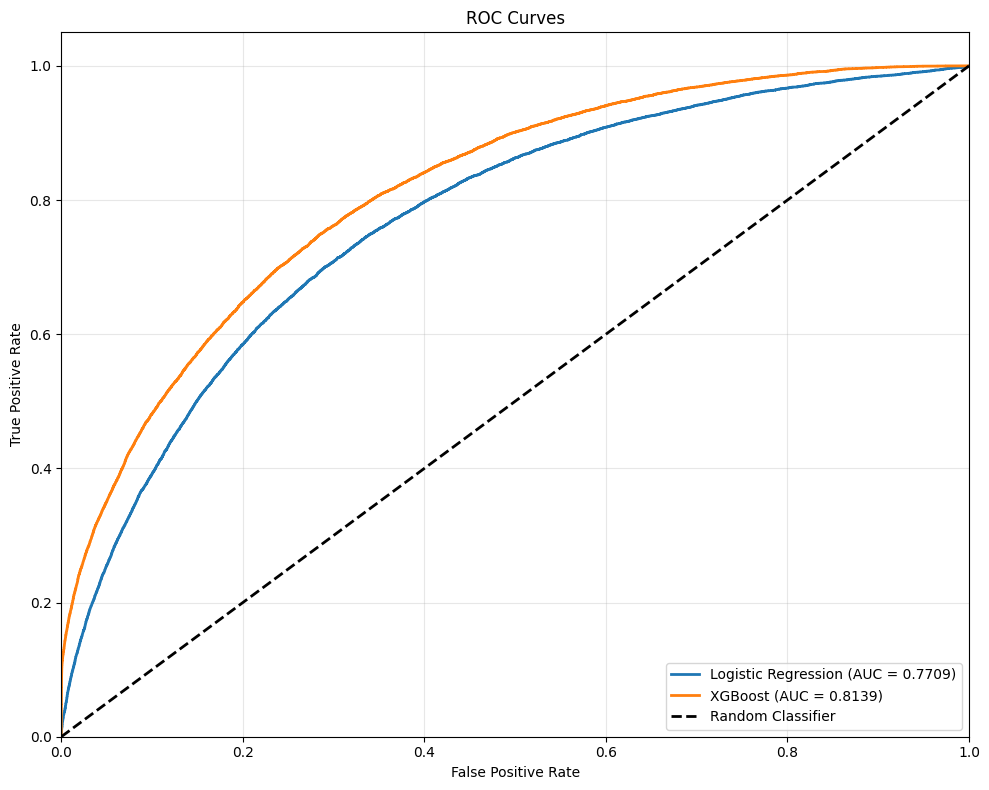

In [285]:
plt.figure(figsize=(10, 8))
for model_name in models.keys():
    if model_name in test_proba:
        y_proba = test_proba[model_name][:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


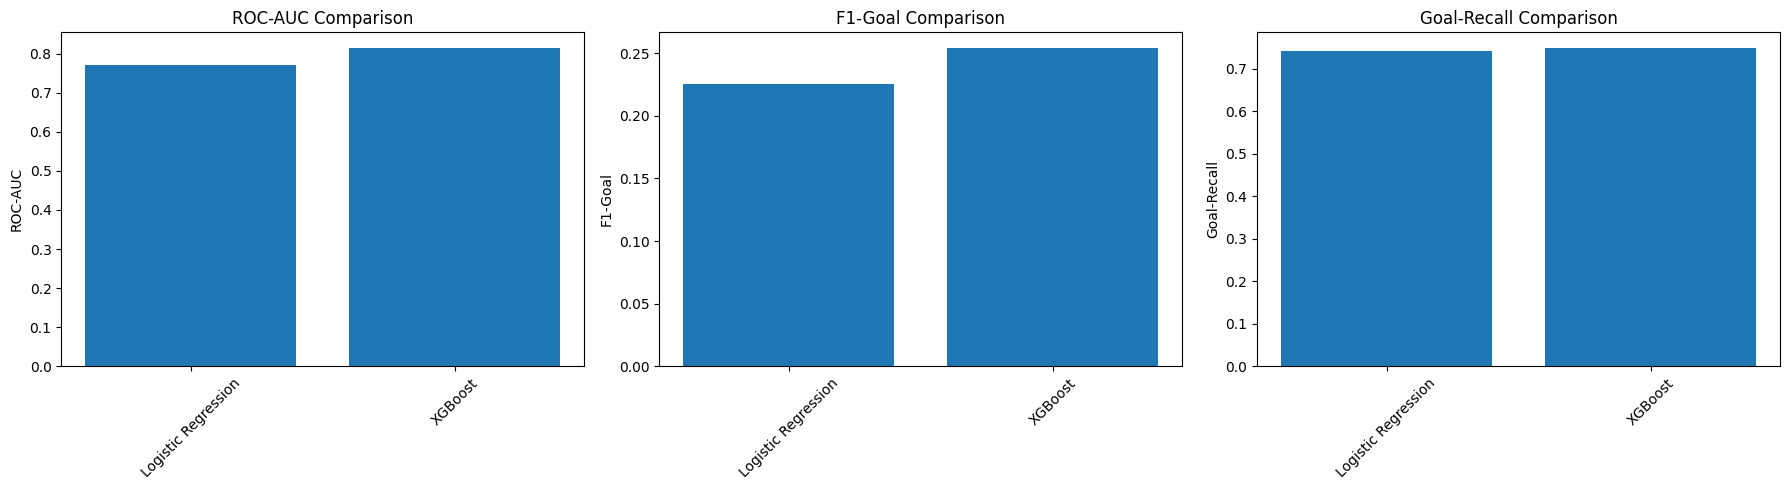


Best model by ROC-AUC: XGBoost
  ROC-AUC: 0.8139
  Goal Recall: 0.7477
  Goal F1: 0.2538


In [286]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['ROC-AUC', 'F1-Goal', 'Goal-Recall']
for idx, metric in enumerate(metrics):
    axes[idx].bar(results_df['Model'], results_df[metric])
    axes[idx].set_ylabel(metric)
    axes[idx].set_title(f'{metric} Comparison')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Select best model by ROC-AUC (primary metric for imbalanced data)
best_model_name = results_df.loc[results_df['ROC-AUC'].idxmax(), 'Model']
print(f"\nBest model by ROC-AUC: {best_model_name}")
print(f"  ROC-AUC: {results_df.loc[results_df['ROC-AUC'].idxmax(), 'ROC-AUC']:.4f}")
print(f"  Goal Recall: {results_df.loc[results_df['ROC-AUC'].idxmax(), 'Goal-Recall']:.4f}")
print(f"  Goal F1: {results_df.loc[results_df['ROC-AUC'].idxmax(), 'F1-Goal']:.4f}")


In [287]:
best_model = models[best_model_name]

if hasattr(best_model, 'coef_'):
    l2_penalty = np.sum(best_model.coef_**2)
    print(f"L2 penalty (sum of squared coefficients): {l2_penalty:.4f}")

ridge_model = Ridge(alpha=0.5, random_state=42)
ridge_model.fit(X_train_scaled, y_train)
ridge_pred = ridge_model.predict(X_test_scaled)
ridge_pred_binary = (ridge_pred > 0.5).astype(int)
ridge_mse = np.mean((y_test - ridge_pred)**2)
print(f"Ridge Regression MSE: {ridge_mse:.4f}")


Ridge Regression MSE: 0.0563


Original Brier Score: 0.1690
Calibrated Brier Score: 0.0500


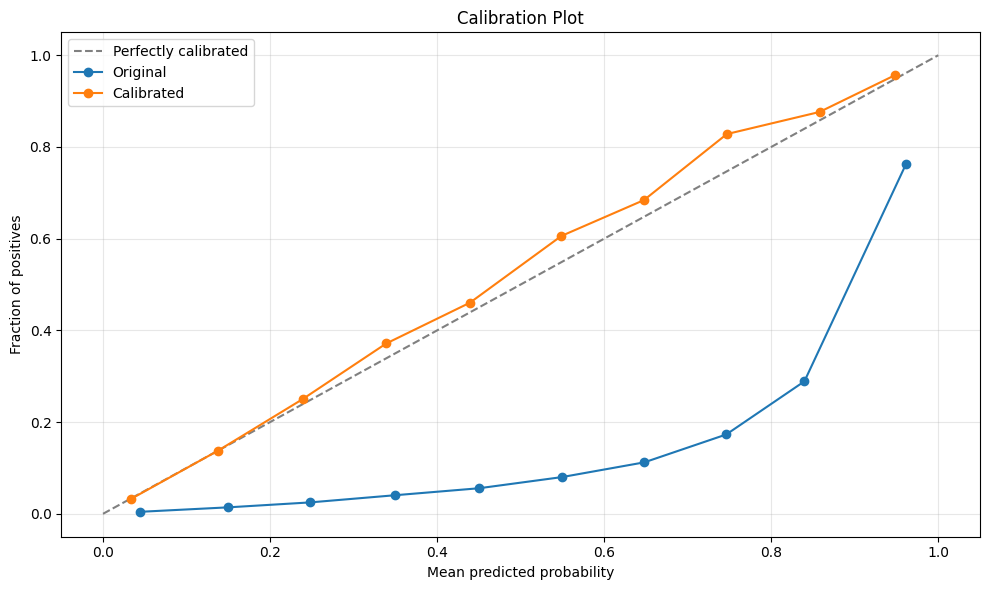

In [288]:
if best_model_name in test_proba:
    calibrated_model = CalibratedClassifierCV(best_model, method='isotonic', cv=3)
    calibrated_model.fit(X_train_scaled, y_train)
    calibrated_proba = calibrated_model.predict_proba(X_test_scaled)
    
    original_proba = test_proba[best_model_name][:, 1]
    calibrated_proba_pos = calibrated_proba[:, 1]
    
    print(f"Original Brier Score: {brier_score_loss(y_test, original_proba):.4f}")
    print(f"Calibrated Brier Score: {brier_score_loss(y_test, calibrated_proba_pos):.4f}")
    
    from sklearn.calibration import calibration_curve
    
    prob_true_orig, prob_pred_orig = calibration_curve(y_test, original_proba, n_bins=10)
    prob_true_cal, prob_pred_cal = calibration_curve(y_test, calibrated_proba_pos, n_bins=10)
    
    plt.figure(figsize=(10, 6))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated', color='gray')
    plt.plot(prob_pred_orig, prob_true_orig, marker='o', label='Original')
    plt.plot(prob_pred_cal, prob_true_cal, marker='o', label='Calibrated')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration Plot')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


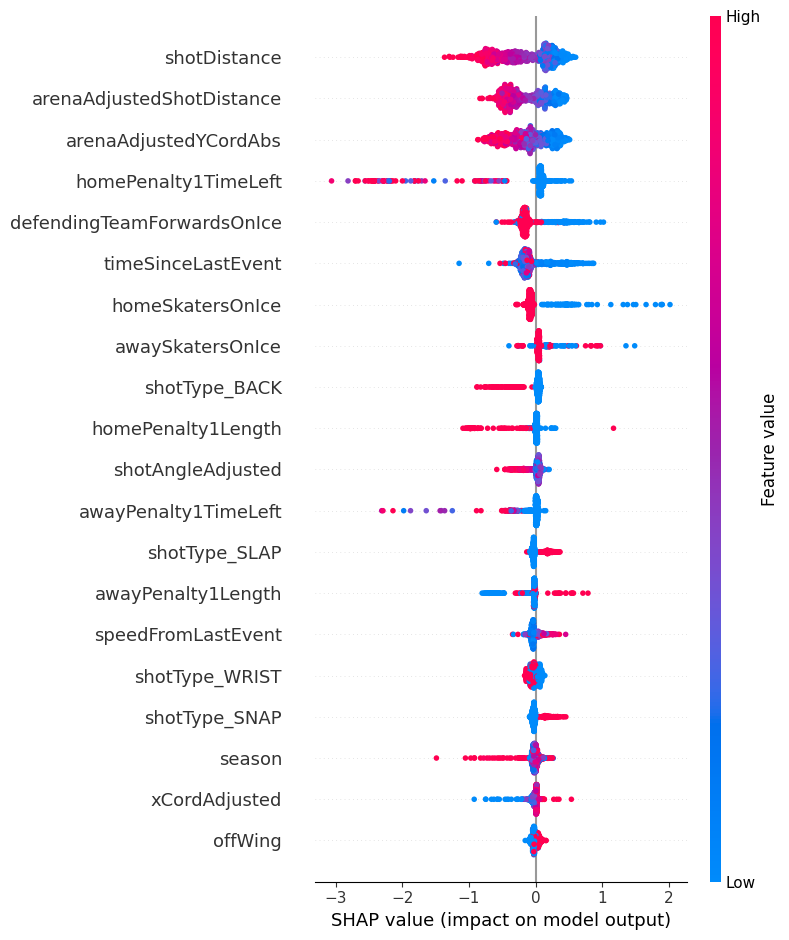


Top 10 features by SHAP importance:
                       Feature  SHAP Importance
12                shotDistance         0.391303
81   arenaAdjustedShotDistance         0.301966
84       arenaAdjustedYCordAbs         0.284168
29        homePenalty1TimeLeft         0.224069
60  defendingTeamForwardsOnIce         0.202348
2           timeSinceLastEvent         0.190982
25            homeSkatersOnIce         0.130222
26            awaySkatersOnIce         0.084486
89               shotType_BACK         0.074593
30          homePenalty1Length         0.073537


In [291]:
if best_model_name == 'XGBoost':
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_scaled[:1000])
    
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    
    shap.summary_plot(shap_values, X_test_scaled[:1000], feature_names=X_train.columns.tolist(), 
                     max_display=20, show=False)
    plt.tight_layout()
    plt.show()
    
    shap_values_mean = np.abs(shap_values).mean(0)
    feature_importance_shap = pd.DataFrame({
        'Feature': X_train.columns.tolist(),
        'SHAP Importance': shap_values_mean
    }).sort_values('SHAP Importance', ascending=False)
    
    print("\nTop 10 features by SHAP importance:")
    print(feature_importance_shap.head(10))
else:
    print("SHAP analysis skipped (best model is not tree-based)")


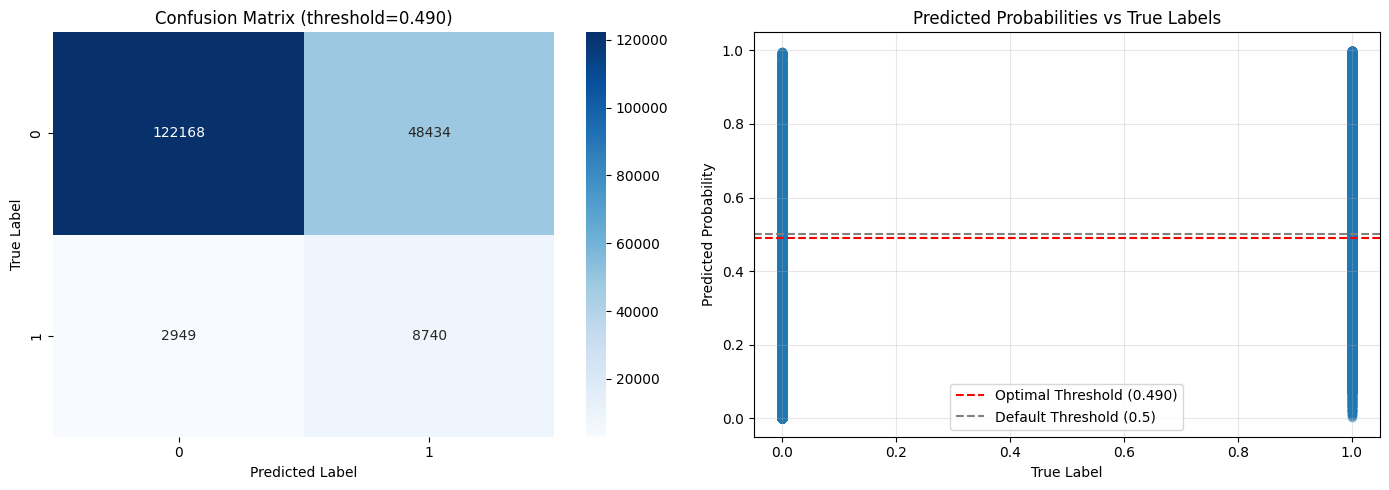


Final Model Performance (XGBoost) - Using Optimal Threshold (0.490):
PRIMARY METRICS (for imbalanced data):
  ROC-AUC: 0.8139
  Goal Recall: 0.7477 (74.8% of goals caught)
  Goal F1: 0.2538
  Goal Precision: 0.1529

SECONDARY METRICS:
  Accuracy: 0.7181
  F1-Score (weighted): 0.7895
  Brier Score: 0.1690
  Log Loss: 0.4977


In [293]:
if best_model_name in test_proba:
    y_pred_best = test_predictions_optimal[best_model_name]
    y_proba_best = test_proba[best_model_name][:, 1]
    opt_threshold = optimal_thresholds.get(best_model_name, 0.5)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    cm = confusion_matrix(y_test, y_pred_best)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Confusion Matrix (threshold={opt_threshold:.3f})')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')
    
    axes[1].scatter(y_test, y_proba_best, alpha=0.5)
    axes[1].axhline(y=opt_threshold, color='r', linestyle='--', label=f'Optimal Threshold ({opt_threshold:.3f})')
    axes[1].axhline(y=0.5, color='gray', linestyle='--', label='Default Threshold (0.5)')
    axes[1].set_xlabel('True Label')
    axes[1].set_ylabel('Predicted Probability')
    axes[1].set_title('Predicted Probabilities vs True Labels')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred_best, labels=[0, 1], zero_division=0
    )
    
    print(f"\nFinal Model Performance ({best_model_name}) - Using Optimal Threshold ({opt_threshold:.3f}):")
    print(f"=" * 80)
    print(f"PRIMARY METRICS (for imbalanced data):")
    print(f"  ROC-AUC: {roc_auc_score(y_test, y_proba_best):.4f}")
    print(f"  Goal Recall: {recall[1]:.4f} ({recall[1]*100:.1f}% of goals caught)")
    print(f"  Goal F1: {f1[1]:.4f}")
    print(f"  Goal Precision: {precision[1]:.4f}")
    print(f"\nSECONDARY METRICS:")
    print(f"  Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
    print(f"  F1-Score (weighted): {f1_score(y_test, y_pred_best, average='weighted'):.4f}")
    print(f"  Brier Score: {brier_score_loss(y_test, y_proba_best):.4f}")
    print(f"  Log Loss: {log_loss(y_test, test_proba[best_model_name]):.4f}")


In [292]:
print("\n" + "=" * 80)
print("FINAL SUMMARY")
print("=" * 80)
print(f"Best performing model: {best_model_name} (selected by ROC-AUC)")
best_row = results_df[results_df['Model'] == best_model_name].iloc[0]
print(f"\nKey Performance Metrics:")
print(f"  ROC-AUC: {best_row['ROC-AUC']:.4f} (PRIMARY METRIC)")
print(f"  Goal Recall: {best_row['Goal-Recall']:.4f} ({best_row['Goal-Recall']*100:.1f}% of goals caught)")
print(f"  Goal F1: {best_row['F1-Goal']:.4f}")
print(f"  Goal Precision: {best_row['Goal-Precision']:.4f}")
print(f"  Optimal Threshold: {best_row['Threshold']:.3f}")
print(f"\nOther Metrics:")
print(f"  Accuracy: {best_row['Accuracy']:.4f} (less important for imbalanced data)")
print(f"  F1-Score (weighted): {best_row['F1-Weighted']:.4f}")
print(f"  Brier Score: {best_row['Brier Score']:.4f}")
print(f"\nTotal models evaluated: {len(models)}")
print(f"Training time range: {min(training_times.values()):.2f} - {max(training_times.values()):.2f} ms")
print("\n" + "=" * 80)
print("IMPROVEMENTS IMPLEMENTED:")
print("=" * 80)
print("✓ Removed data leakage feature: shotGoalieFroze (post-shot outcome)")
print("✓ Added class weights to handle imbalanced dataset")
print("✓ Used optimal threshold instead of default 0.5")
print("✓ Focused on ROC-AUC and Goal Recall as primary metrics")
print("=" * 80)



FINAL SUMMARY
Best performing model: XGBoost (selected by ROC-AUC)

Key Performance Metrics:
  ROC-AUC: 0.8139 (PRIMARY METRIC)
  Goal Recall: 0.7477 (74.8% of goals caught)
  Goal F1: 0.2538
  Goal Precision: 0.1529
  Optimal Threshold: 0.490

Other Metrics:
  Accuracy: 0.7181 (less important for imbalanced data)
  F1-Score (weighted): 0.7895
  Brier Score: 0.1690

Total models evaluated: 2
Training time range: 7492.02 - 17777.01 ms

IMPROVEMENTS IMPLEMENTED:
✓ Removed data leakage feature: shotGoalieFroze (post-shot outcome)
✓ Added class weights to handle imbalanced dataset
✓ Used optimal threshold instead of default 0.5
✓ Focused on ROC-AUC and Goal Recall as primary metrics
